# Description:

7-Eleven is one of the world's major retail stores with a strong presence in US as well. But currently,
 the company has a problem with understanding demand patterns which leads to inventory and budget allocation related issues.
 In order to address the same, the company has tasked us with devising a model which can predict the upcoming demand (sales) in a fairly accurate manner. 
 
 The data consists of sales for 45 country-wide stores located in different regions.
7-Eleven runs promotions throughtout the year which include Super Bowl, Labour Day, Thanksgiving, and Christmas.

Dataset information:

This data contains sales and realted information from 2010-02-05 to 2012-11-01, in the file seven_eleven_sales. There are following fields in the file :

* Store - Store 
* Date - Sale date
* Weekly_Sales -  sales for the store on a given date
* Holiday_Flag - 1/0 depending on holiday period or not
* Temperature - Temperature on the sale day
* Fuel_Price - Fuel price on sale day in that region
* CPI – current consumer price index
* Unemployment - current unemployment rate
* Holiday Events
#### Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
#### Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
#### Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
#### Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

### Objective:
- Understand the problem and the data
- Clean up and transform data as per requirement
- Build a Linear Regression model and predict sales for upcoming time period 
- Measure the performance of the model

#  Steps towards buiding a Solution

**In this notebook, we'll go through following sections -** 

1. Setting up libraries & Ingesting Data
2. Data Wrangling & EDA
3. Feature Engineering 
    * Data Manipulation
    * Feature Scaling
    * Feature Selection
4. Modelling using Multiple Linear Regression
5. Summary

# 1. Setting up libraries & Ingesting Data
**Importing the basic librarires**

In [1]:
import math                
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



from statsmodels.formula import api                
from sklearn.linear_model import LinearRegression   
from sklearn.feature_selection import RFE          
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 

**Setting the default figure size for notebook**

In [2]:
plt.rcParams['figure.figsize'] = [10,6]

**Importing the dataset**

In [3]:
url = "https://drive.google.com/file/d/1QDzTkza7G4ToamjVs_klCO02lcs66S95/view?usp=sharing"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv(url) 
display(df.head())

sales = df.copy(deep=True)
print('\n\033[1mFindings:\033[0m The given sales data consists of {} data entries (rows) across {} columns.'.format(sales.shape[0], sales.shape[1]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Findings: The given sales data consists of 6435 data entries (rows) across 8 columns.


#  2. Data Wrangling & EDA
**Treating Date Variable**

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

df['weekday'] = df['Date'].dt.weekday
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

df.drop(['Date'], axis=1, inplace=True)

df.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [5]:
target = 'Weekly_Sales'

features = [i for i in df.columns if i not in [target]]
sales = df.copy(deep=True)

features

['Store',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'weekday',
 'month',
 'year']

**Checking for NULLS and analysing datatypes of all columns**

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [7]:
display(sales.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


##### Findings: 

* The data seems to be fairly accurate. There might be a few outliers which we'll inspect soon but overall the numbers seem reasonable.

**Duplicates & Null Value checks**

In [8]:
rows,cols = sales.shape

df.drop_duplicates(inplace=True)

if df.shape==(rows,cols):
    print("No duplicates")
else:
    print('Duplicates removed ---> '+ str(rows-df.shape[0]))

No duplicates


In [9]:
null_cnt = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
null_cnt['Percentage'] = round(null_cnt['Total Null Values']/df.shape[0],3)*100
print('Total null values - ' + str(null_cnt))

Total null values -               Total Null Values  Percentage
Store                         0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
weekday                       0         0.0
month                         0         0.0
year                          0         0.0


##### Findings:
**We can see that there are no Null values in the data**

**Checking unique values across each column to ge more insights into features, specially categorical features -**

In [10]:
sales.nunique().sort_values(ascending=False)

Weekly_Sales    6435
Temperature     3528
CPI             2145
Fuel_Price       892
Unemployment     349
Store             45
month             12
weekday            7
year               3
Holiday_Flag       2
dtype: int64

**Checking number of Categorical and Numerical features -**

In [11]:
len(features)

9

In [12]:
unique = df[features].nunique().sort_values(ascending=False)
num_f = []
cat_f = []

for i in range(sales[features].shape[1]):
    if unique.values[i]<=45:cat_f.append(unique.index[i])
    else: num_f.append(unique.index[i])

print('\n\033[1mFindings:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(num_f),len(cat_f)))


Findings: The Datset has 4 numerical & 5 categorical features.


###  Univariate Analysis of Target Variable

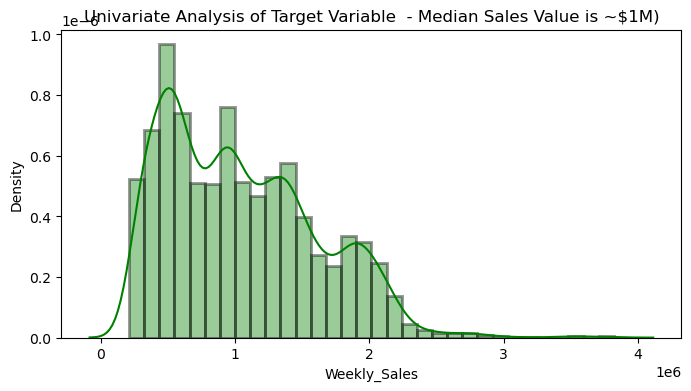

In [13]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2.1), bins=32)
plt.title('Univariate Analysis of Target Variable  - Median Sales Value is ~$1M)')
plt.show()

##### **Finding:** 

* The Target Variable seems to be be slightly right skewed,meaning there are more instances of sales at lower values than at higher.

###  Univariate Analysis of categorical features

Univariate Analysis of categorical features:


<Figure size 1500x900 with 0 Axes>

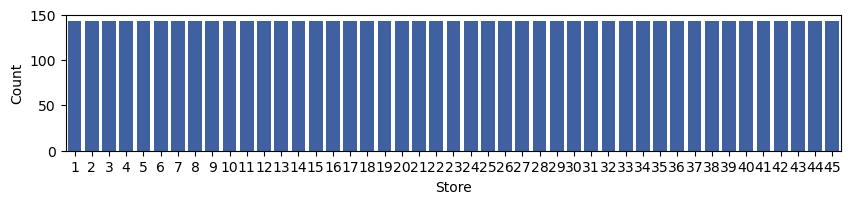

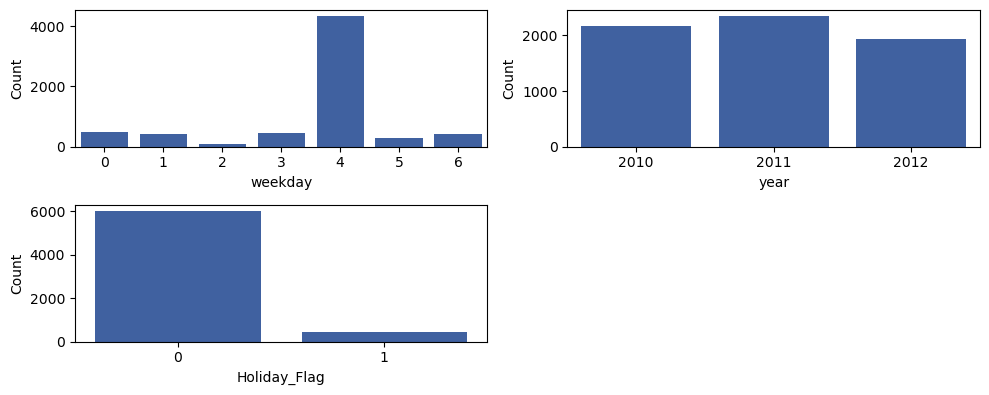

In [14]:
print('\033[1mUnivariate Analysis of categorical features:')
n = 2
num_categories = len(cat_f)
num_plots = math.ceil(num_categories / n)

plt.figure(figsize=(15, 3 * num_plots))

for i in range(num_categories):
    if sales[cat_f[i]].nunique() <= 8:
        plt.subplot(num_plots, n, i + 1)
        sns.countplot(sales[cat_f[i]], color="#305cb0")
    else:
        plt.figure(figsize=(10, 6))
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(sales[cat_f[i]], color="#305cb0")
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Insights:** 

* There are about 500 entries of weekly sales which correspond to holiday period,out of 6500.


* We have more weekly sales entries for 2011 and lesser entries for other years.This is expected since we know the given data is not for entire duration of all 3 years. 

* All stores have equal entries for weekly sales - 143 Entries. Which seems correct as 143 * 45  = 6435, which we know are the number of rows in data


4. Since this analysis only represents the "count of entries",the month-wise graph is insignificant as we know each month has fixed number of weeks and we have fixed number of stores as well (45)

###  Univariate Analysis of Numerical Variables

                                                Numeric Features Distribution                                                 


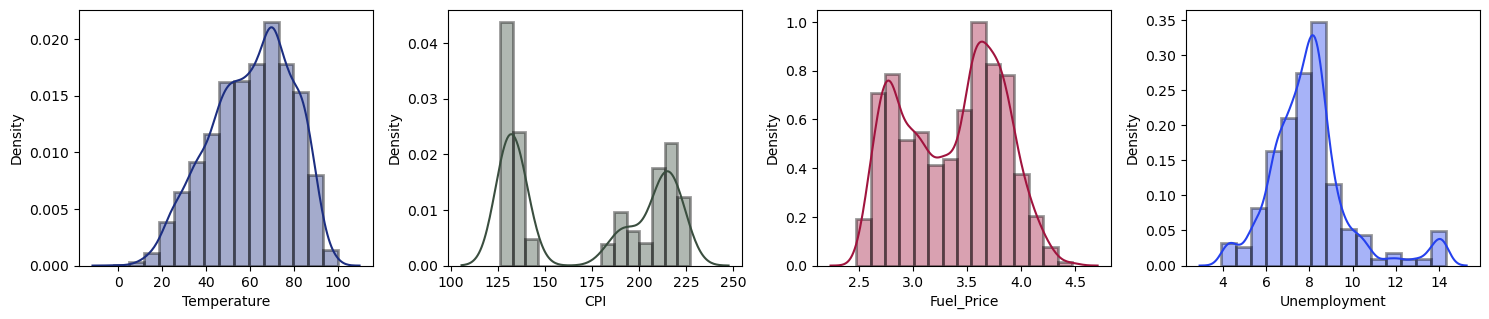

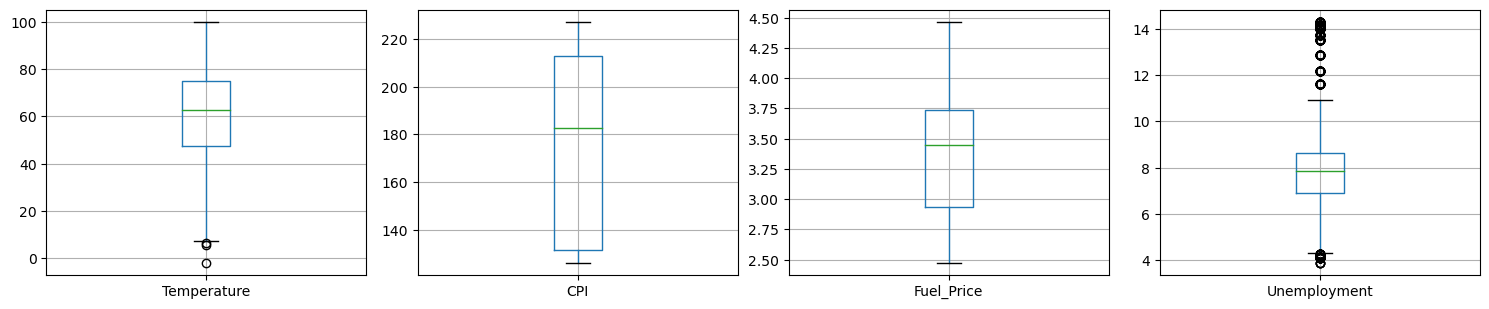

In [15]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

n=4


plt.figure(figsize=[15,6*math.ceil(len(num_f)/n)])
for i in range(len(num_f)):
    plt.subplot(2,4,i+1) #only 4 graphs are to be plot but 2,4 is used to adjust size
    sns.distplot(df[num_f[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=15,
                 color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(num_f)/n)])
for i in range(len(num_f)):
    plt.subplot(2,4,i+1)
    df.boxplot(num_f[i])
plt.tight_layout()
plt.show()

**Findings:** 

* There seem to be some outliers in a few numerical features. It is better to fix these before model building for a better model.

* CPI follows a Bi-Modal distribution, hence one needs to be careful that the model algorythm should support such features.


* All other features follow Normal Distrubution.

###  Bi-Variate Analysis of Numerical features to check for collinearity

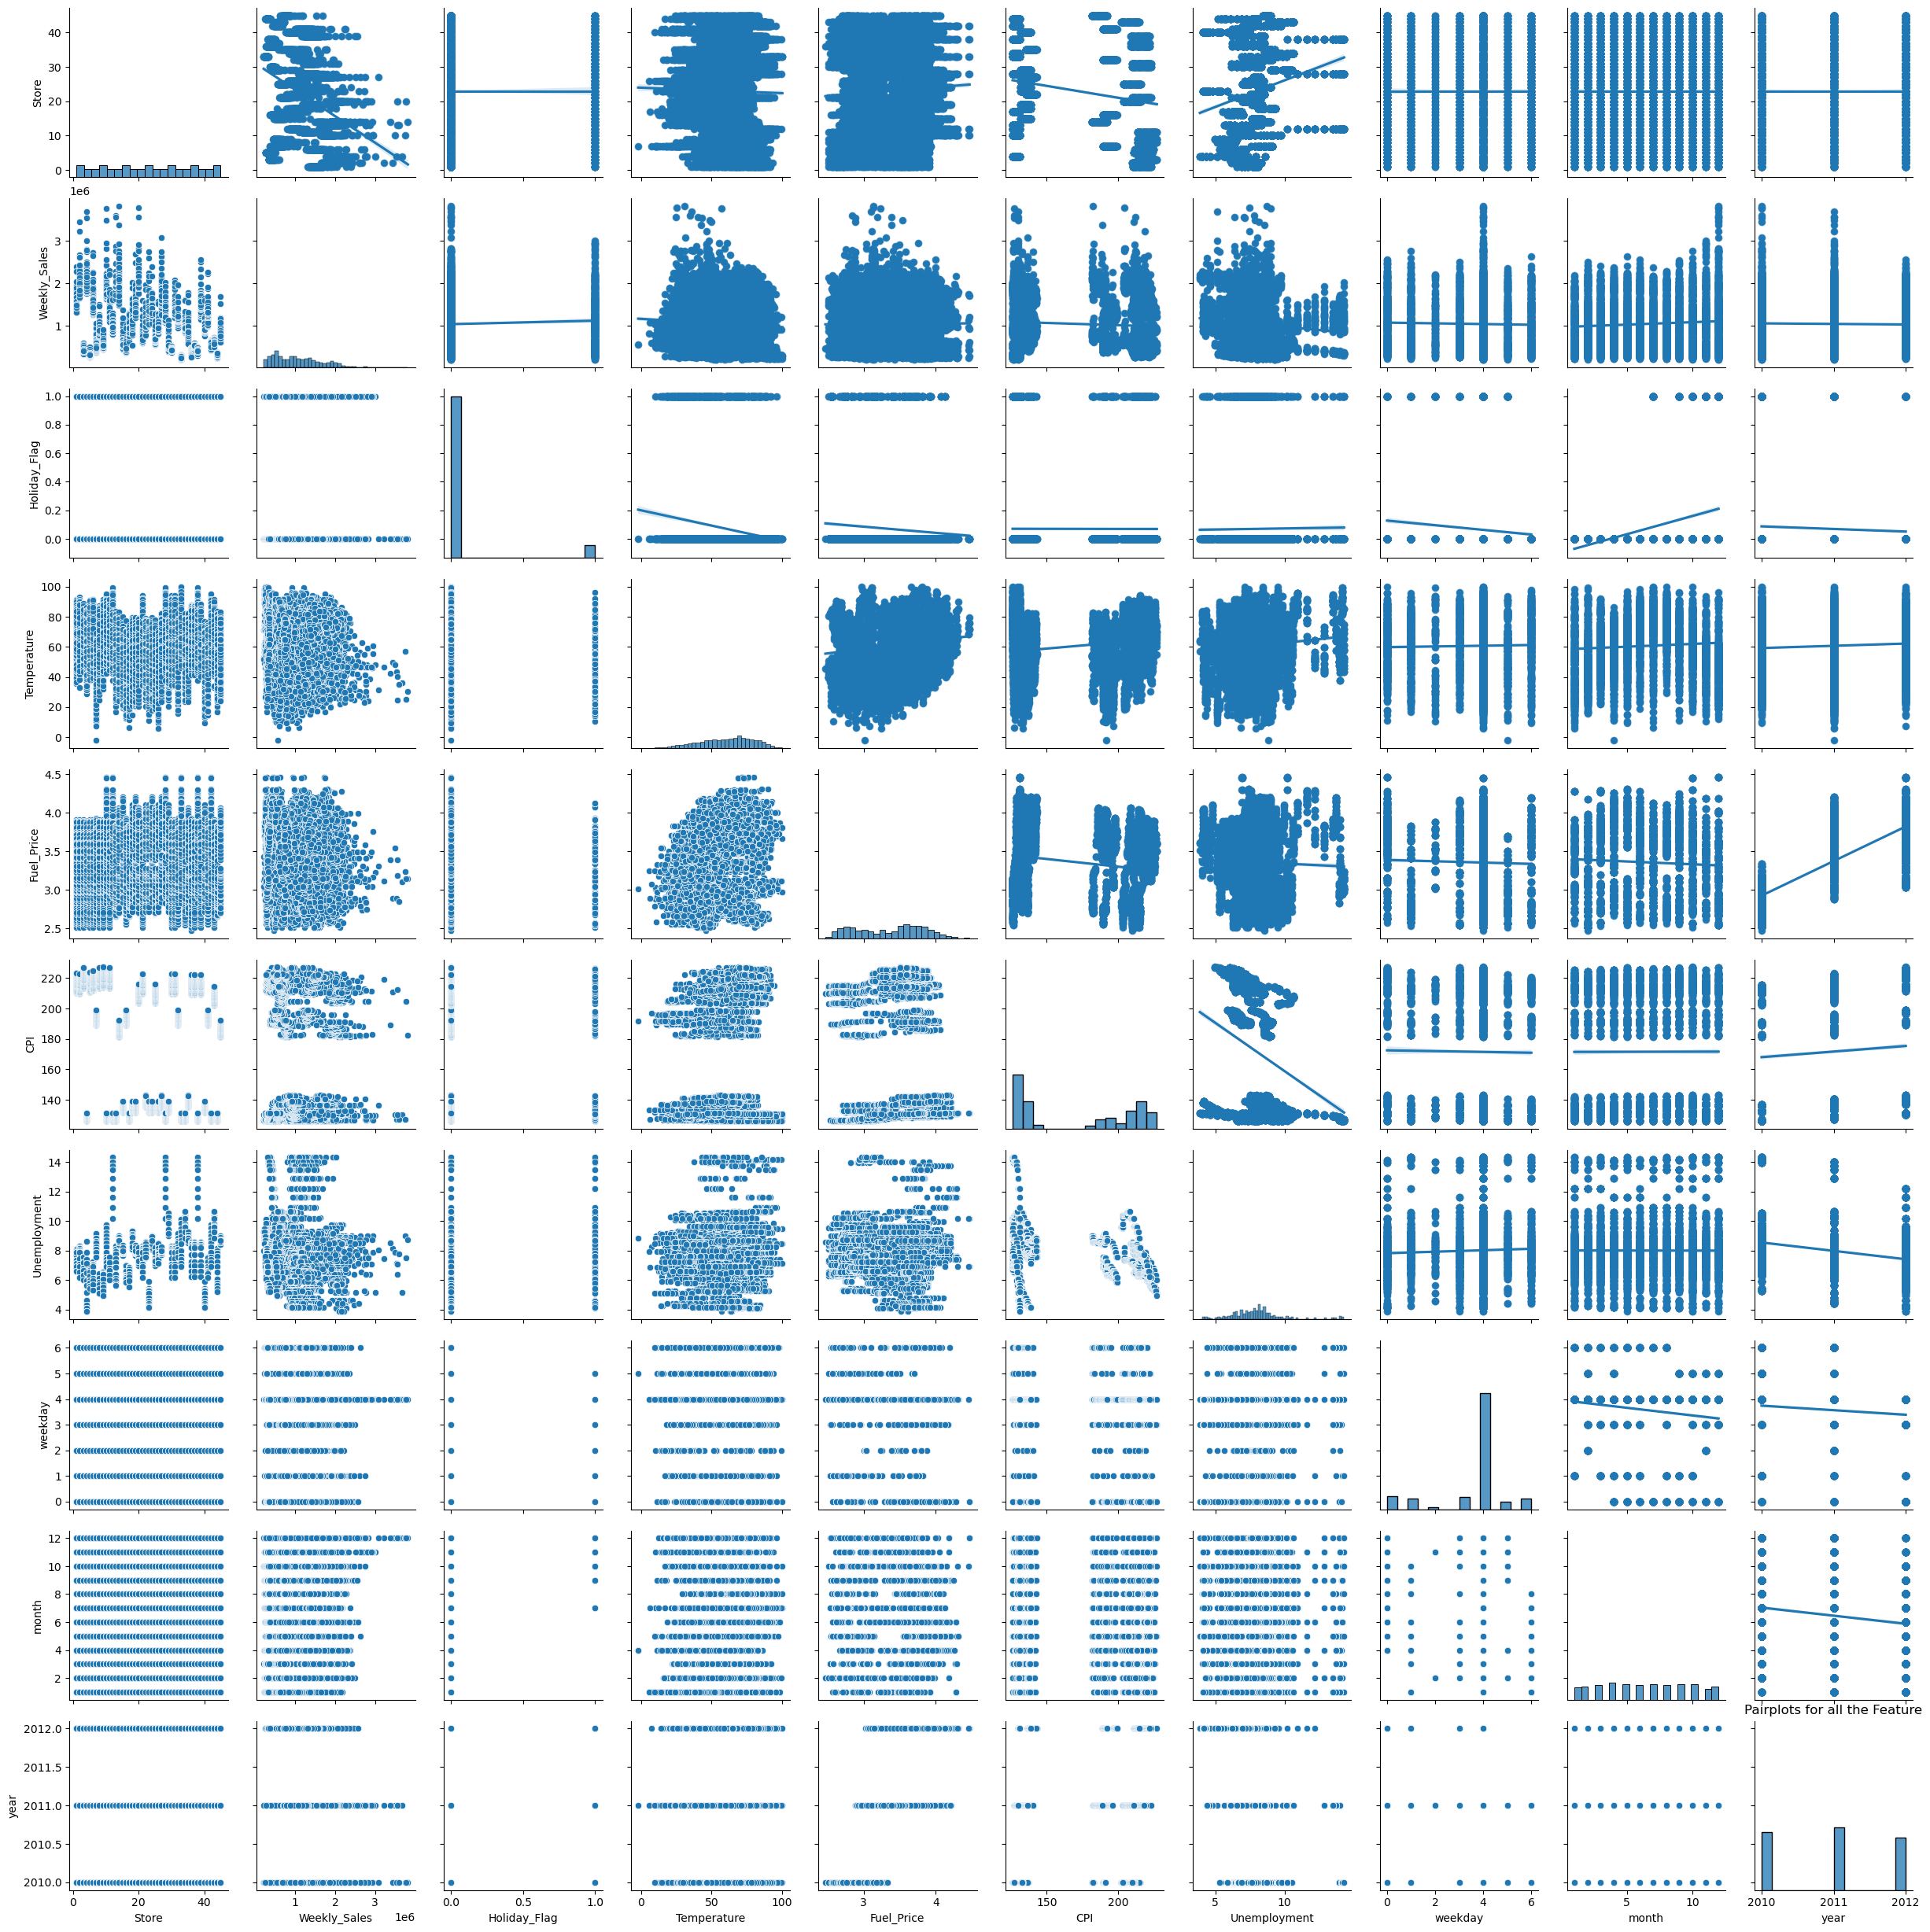

In [16]:
pair_plot = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
pair_plot.map_upper(sns.regplot)
plt.show()

##### **Findings:** 




* Some features in the above plot seem to be correlated. Let's check this further by plotting correlation using Heatmap.

#### Collinearity Check | Heatmap

<AxesSubplot:>

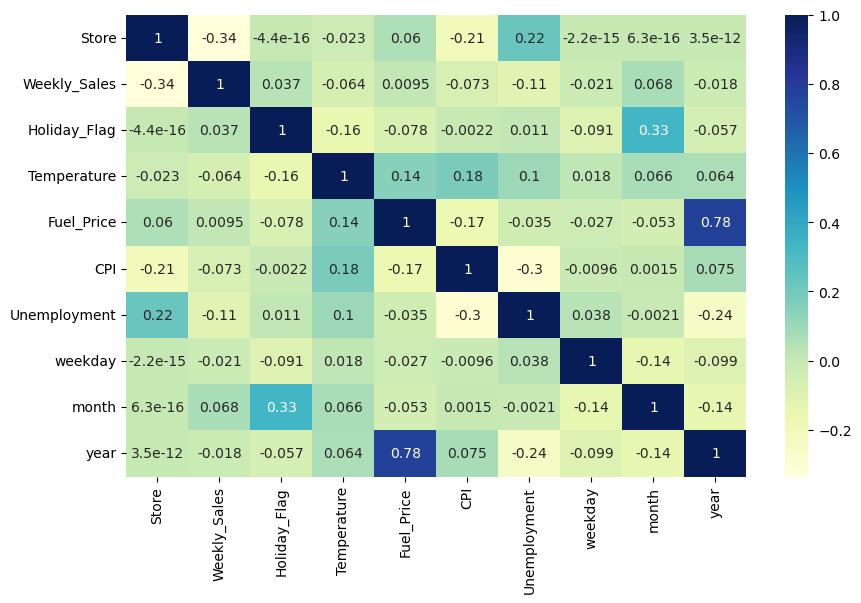

In [17]:
heatmap_data=df.corr()
sns.heatmap(heatmap_data, cmap='YlGnBu', annot = True)

##### **Findings:**
* We can confirm that a lot of pairs have high correlation among them.


###  Bi-variate analysis of sales across different categorical features



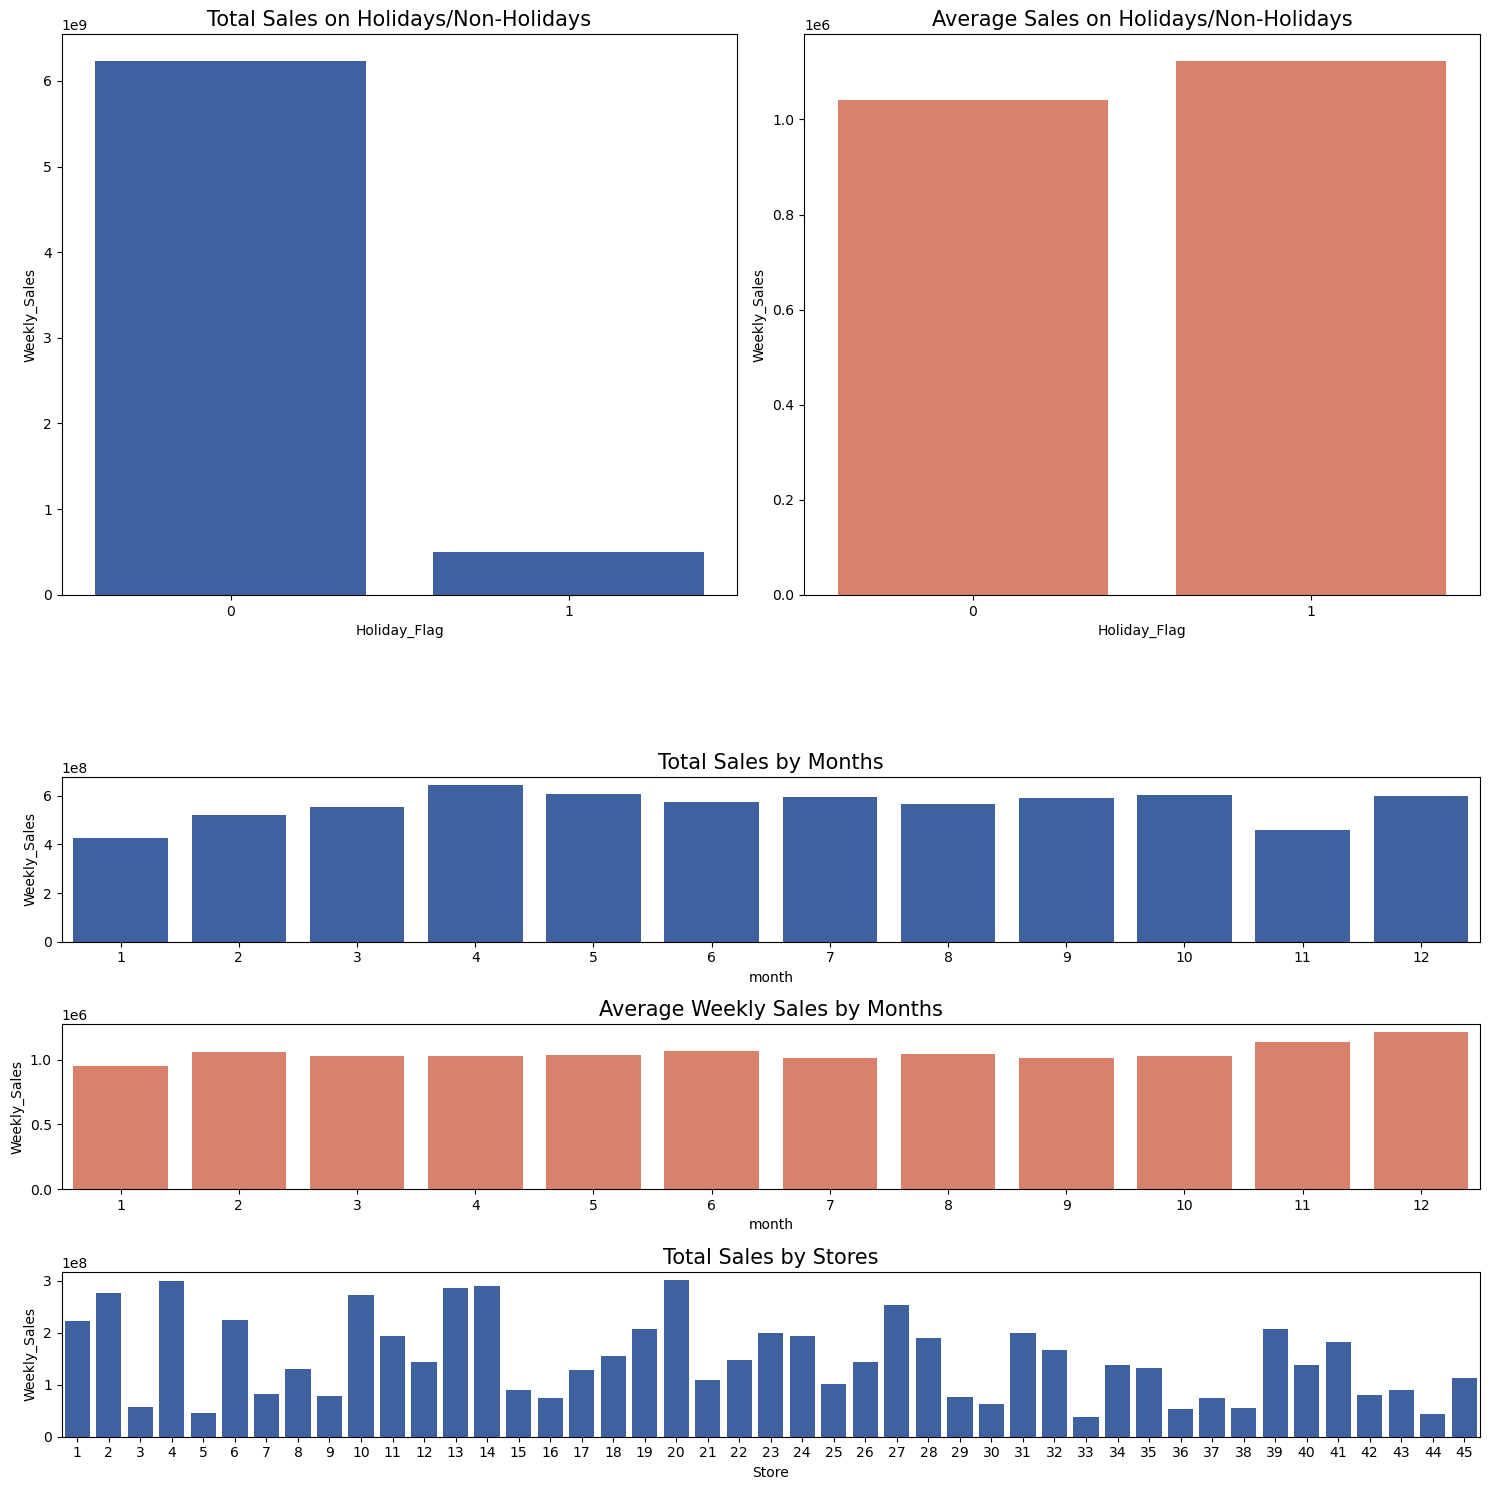

In [18]:
plt.figure(figsize=[15,15])                                                              
                                                                                         

plt.subplot(2,2,1)                                                     
grouped_sales = df[['Holiday_Flag','Weekly_Sales']].groupby('Holiday_Flag').sum()                                                                                               
sns.barplot(y='Weekly_Sales', x=grouped_sales.index, color="#305cb0",data=grouped_sales) 
plt.title('Total Sales on Holidays/Non-Holidays', size = 15)                             


plt.subplot(2,2,2)                                                 
grouped_sales_sum = df[['Holiday_Flag','Weekly_Sales']].groupby('Holiday_Flag').sum()                                                                                       
grouped_sales_count = df[['Holiday_Flag','Weekly_Sales']].groupby('Holiday_Flag').count()                                                                                               
avg_weekly_sales = grouped_sales_sum['Weekly_Sales']/grouped_sales_count['Weekly_Sales'] 
sns.barplot(y=avg_weekly_sales, x=grouped_sales_sum.index, color="#ed7658")              
plt.title('Average Sales on Holidays/Non-Holidays', size = 15)                          


plt.subplot(6,1,4)                                                     
grouped_sales = df[['month','Weekly_Sales']].groupby('month').sum()                                                                                                           
sns.barplot(y='Weekly_Sales', x=grouped_sales.index, color="#305cb0",data=grouped_sales) 
plt.title('Total Sales by Months', size = 15)                                            


plt.subplot(6,1,5)                                                     
grouped_sales_sum = df[['month','Weekly_Sales']].groupby('month').sum()                                                                                                      
grouped_sales_count = df[['month','Weekly_Sales']].groupby('month').count()                                                                                                   
avg_weekly_sales = grouped_sales_sum['Weekly_Sales']/grouped_sales_count['Weekly_Sales']                                                                                          
sns.barplot(y=avg_weekly_sales, x=grouped_sales_sum.index, color="#ed7658")                                                                                                     
plt.title('Average Weekly Sales by Months', size = 15)    


plt.subplot(6,1,6)                                                     
grouped_sales_sum = df[['Store','Weekly_Sales']].groupby('Store').sum()                                                                                                       
sns.barplot(y='Weekly_Sales', x=grouped_sales_sum.index, color="#305cb0",data=grouped_sales_sum)                                                                                          
plt.title('Total Sales by Stores', size = 15)                                            
plt.tight_layout() 

**Insights** :

* Although 90+ % of the sales are from Non_holidays but the average weekly sales are higher for Holiday period by about 10%.

* Although in terms of total sales-  April,July,September,October and December show better performance. But since we have uneven data across months,
 it is more useful to look at "Average sales" rather than totals.

* As per average sale by months plot, average sales are higher in November and December.
 ( Which is expected because of holidays in Nov and Dec). Feb, June and August also show good results. 

* Despite holiday in september, the sales are not impacted significantly

* Thus we can conclude that month and holiday flag are going to be crucial feature in our model. 

* As per the last plot, we can see that sales number vary a lot as per the store. Thus, it can be a significant feature in our model.

---

#  3. Feature Engineering and Feature Selection

###  Feature Engineering | One Hot Encoding

In [19]:
categories_dummy = pd.DataFrame()
for category in cat_f:
    categories_dummy = pd.concat([categories_dummy,pd.get_dummies(df[category],drop_first=False,prefix=str(category))],axis=1)
categories_dummy.shape

(6435, 69)

In [20]:
categories_dummy.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year_2010,year_2011,year_2012,Holiday_Flag_0,Holiday_Flag_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


**Merging dummies with main data**

In [21]:
sales_dummy = pd.concat([df,categories_dummy],axis=1)
sales_dummy.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year_2010,year_2011,year_2012,Holiday_Flag_0,Holiday_Flag_1
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010,...,0,0,0,0,1,1,0,0,1,0
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010,...,0,1,0,0,0,1,0,0,0,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010,...,0,0,1,0,0,1,0,0,1,0
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010,...,0,0,1,0,0,1,0,0,1,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010,...,0,0,0,0,0,1,0,0,1,0


###  Feature Engineering | Outlier Treatment

In [22]:
num_f

['Temperature', 'CPI', 'Fuel_Price', 'Unemployment']

In [23]:
sales_new = sales_dummy.copy()


for i in num_f:
    quartile1 = sales_new[i].quantile(0.25)
    quartile3 = sales_new[i].quantile(0.75)
    inter_quartile_range = quartile3 -quartile1
    sales_new = sales_new[sales_new[i] <= (quartile3+(1.5*inter_quartile_range))]
    sales_new = sales_new[sales_new[i] >= (quartile1-(1.5*inter_quartile_range))]
    sales_new = sales_new.reset_index(drop=True) 
display(sales_new.head())

print('Before outlier removal, the dataset had {} rows'.format(sales_dummy.shape[0]))
print('After outlier removal, the dataset has {} rows'.format(sales_new.shape[0]))

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year_2010,year_2011,year_2012,Holiday_Flag_0,Holiday_Flag_1
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010,...,0,0,0,0,1,1,0,0,1,0
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010,...,0,1,0,0,0,1,0,0,0,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010,...,0,0,1,0,0,1,0,0,1,0
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010,...,0,0,1,0,0,1,0,0,1,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010,...,0,0,0,0,0,1,0,0,1,0


Before outlier removal, the dataset had 6435 rows
After outlier removal, the dataset has 5951 rows


# Visualising final Dataset shape after outlier removals

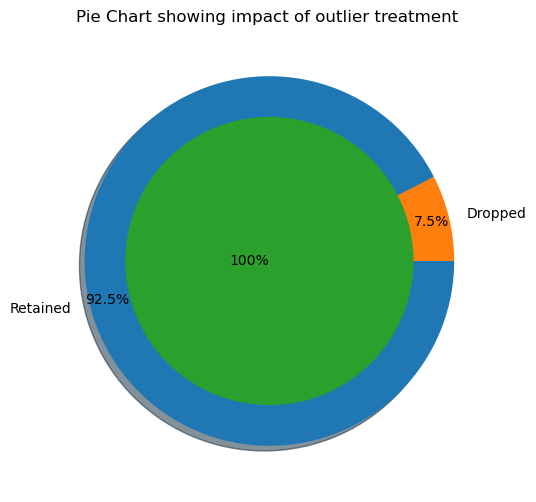

In Outlier Treatment, 484 samples were dropped, while reatining 92.48% of the rows.


In [24]:
plt.title('Pie Chart showing impact of outlier treatment ')
plt.pie([sales_new.shape[0], sales.shape[0]-sales_new.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, shadow=True)

plt.pie([sales_new.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)

plt.show()

print(f'In Outlier Treatment, {sales.shape[0]-sales_new.shape[0]} samples were dropped, \
while reatining {round(100 - ((sales.shape[0]-sales_new.shape[0])*100/(df.shape[0])),2)}% of the rows.')

###  Feature Engineering | Standardization

In [25]:
target = 'Weekly_Sales'

features = [i for i in sales_new.columns if i not in [target]]
sales_model = sales_new.copy(deep=True)


In [26]:
unique = sales_model[features].nunique().sort_values(ascending=False)
num_f = []
cat_f = []

for i in range(sales_model[features].shape[1]):
    if unique.values[i]<=45:cat_f.append(unique.index[i])
    else: num_f.append(unique.index[i])

In [27]:
X = sales_model.drop(target, axis=1)
Y = sales_model[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=100)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_f),
        ('cat', 'passthrough', cat_f)
    ])


pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

train_X = pipeline.fit_transform(Train_X)
train_X = pd.DataFrame(train_X, columns=num_f + cat_f)

test_X = pipeline.transform(Test_X)
test_X = pd.DataFrame(test_X, columns=num_f + cat_f)

train_X.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
Train_Y.reset_index(drop=True, inplace=True)
Test_Y.reset_index(drop=True, inplace=True)

print('Data before Train/Test Split: X shape:', X.shape, ' Y shape:', Y.shape)
print('Train dataset: train_X shape:', train_X.shape, ' Train_Y shape:', Train_Y.shape)
print('Test dataset: test_X shape:', test_X.shape, ' Test_Y shape:', Test_Y.shape)

Data before Train/Test Split: X shape: (5951, 78)  Y shape: (5951,)
Train dataset: train_X shape: (4463, 78)  Train_Y shape: (4463,)
Test dataset: test_X shape: (1488, 78)  Test_Y shape: (1488,)


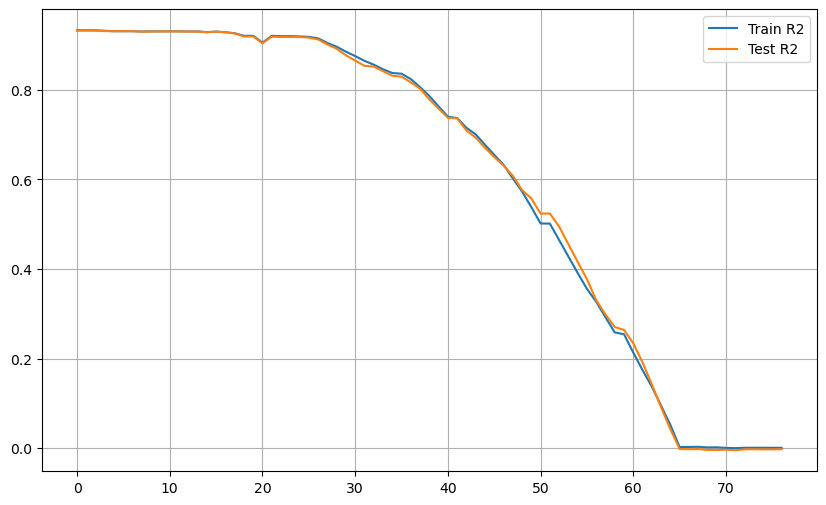

In [29]:
train_r2=[]
test_r2=[] 


max_features=sales_model.shape[1]-2
for i in range(max_features):                                 # Running iteratively an RFE function with 
                                                              # decreasing number of features to be dropped each time
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=train_X.shape[1]-i)       
    rfe = rfe.fit(train_X, Train_Y)                           # The output of RFE.fit() will be an object. 
                                                            

    LR = LinearRegression()
    LR.fit(train_X.loc[:,rfe.support_], Train_Y)              # Fitting a multiple linear regression model based on RFE selected features

    pred_train = LR.predict(train_X.loc[:,rfe.support_])      # Predicting Target for Train set
    pred_test = LR.predict(test_X.loc[:,rfe.support_])        # Predicting Target for Test set

    train_r2.append(r2_score(Train_Y, pred_train))            # R2 Score for Train set
    test_r2.append(r2_score(Test_Y, pred_test))               # R2 Score for Test set


plt.plot(train_r2, label='Train R2')
plt.plot(test_r2, label='Test R2')

plt.legend()
plt.grid()
plt.show()

#### Finding :
* It can be seen that R2 score remains fairly constant until RFE had dropped around 30 features, after which it start to decline sharply.

* Hence we will be removing 30 features suggested by RFE in next step for training our MLR model.

##### Final Feature Selection Step

In [30]:
lm = LinearRegression()
rfe_features = RFE(lm,n_features_to_select=train_X.shape[1]-30)            
rfe_features = rfe_features.fit(train_X, Train_Y)

LR = LinearRegression()
LR.fit(train_X.loc[:,rfe_features.support_], Train_Y)  # rfe_features.support_ provides an array of True/False which essentially helps in selecting the best and most efficient features.


pred_train = LR.predict(train_X.loc[:,rfe_features.support_])
pred_test = LR.predict(test_X.loc[:,rfe_features.support_])

print(r2_score(Train_Y, pred_train))
print(r2_score(Test_Y, pred_test))

0.8749008027176725
0.8649344535560227


**Thus, even after dropping 30 features, model still gives a good accuracy of about 86.4%**

**This confirms our initial understanding of colliniarity in the data**

In [31]:
# Storing our new reduced data in new variables for model training 
Train_X_std_rfe = train_X.loc[:,rfe_features.support_]
Test_X_std_rfe = test_X.loc[:,rfe_features.support_]

In [32]:
Train_X_std_rfe.columns

Index(['weekday', 'Store_44', 'Store_45', 'Store_40', 'Store_43', 'Store_42',
       'Store_41', 'Store_38', 'Store_37', 'weekday_4', 'Holiday_Flag_0',
       'year_2012', 'year_2011', 'year_2010', 'weekday_6', 'weekday_5',
       'weekday_3', 'weekday_2', 'weekday_1', 'weekday_0', 'Store_35',
       'Store_36', 'Store_31', 'Store_34', 'Store_8', 'Store_12', 'Store_11',
       'Store_9', 'Store_7', 'Store_16', 'Store_5', 'Store_3', 'Store_15',
       'Store_17', 'Store_33', 'Store_26', 'Store_32', 'Holiday_Flag',
       'Store_30', 'Store_29', 'Store_28', 'Store_25', 'Store_18', 'Store_24',
       'Store_23', 'Store_22', 'Store_21', 'Holiday_Flag_1'],
      dtype='object')

# 4. Model Training and Evaluation | Multiple Linear Regression

###  Model Training

In [33]:
# Model Training | Multiple Linear Regression ( on reduced data after RFE )

MLR = LinearRegression().fit(Train_X_std_rfe,Train_Y)

print('{}{}\033[1m Coefficients & Intercept of Trained MLR model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))

print('\nThe Coeffecient of the MLR model is ',MLR.coef_)

print('\n\nThe Intercept of the MLR model is',MLR.intercept_)

<<<----------------------------------- Coefficients & Intercept of Trained MLR model ----------------------------------->>>


The Coeffecient of the MLR model is  [ 1.65953902e+16 -1.49980966e+06 -1.03035457e+06 -8.39621085e+05
 -1.16944909e+06 -1.24728155e+06 -5.34457782e+05 -1.35450878e+06
 -1.28408800e+06 -1.48577467e+17  5.33398606e+16  5.06408148e+16
  5.06408148e+16  5.06408148e+16 -1.81768247e+17 -1.65172857e+17
 -1.31982077e+17 -1.15386686e+17 -9.87912962e+16 -8.21959059e+16
 -8.84956548e+05 -1.42726731e+06 -4.09658792e+05 -8.33569153e+05
 -8.89460489e+05 -8.18543321e+05 -4.45304618e+05 -1.26312468e+06
 -1.23827235e+06 -1.28621051e+06 -1.48921513e+06 -1.40007992e+06
 -1.18838399e+06 -9.10231961e+05 -1.54216252e+06 -8.08491861e+05
 -6.40172641e+05  3.07499826e+16 -1.36438257e+06 -1.26133637e+06
 -5.22788194e+05 -1.10226669e+06 -7.01800276e+05 -4.45099076e+05
 -4.36432347e+05 -7.70027061e+05 -1.04392593e+06  2.25898780e+16]


The Intercept of the MLR model is -2.1784769399786756e

### Defining a Model Evaluation function

In [34]:
two_random_features_for_scatter =np.random.choice(Train_X_std_rfe.columns.values,2,replace=False)


def Evaluation( pred_train,pred_test):
    
    # Part -1 Plotting Residual Plots & Predicted Target vs Actual Target to understand the spread
    
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Test_Y - pred_test))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Test_Y,pred_test)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()
    


    # Part -2 Evaluating the Model ( by R2 )

    print('\n\n{}Training Set Evaluation{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred_train),20))


    print('\n{}Testing Set Evaluation{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred_test),20))
    
    # Part -3 Plotting scatter plots for predicted data vs the real datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(two_random_features_for_scatter):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std_rfe[i], label='Actual')
        plt.scatter(y=pred_train, x=Train_X_std_rfe[i], label='Prediction')
        plt.legend()
    plt.show()


--------------------Residual Plots--------------------


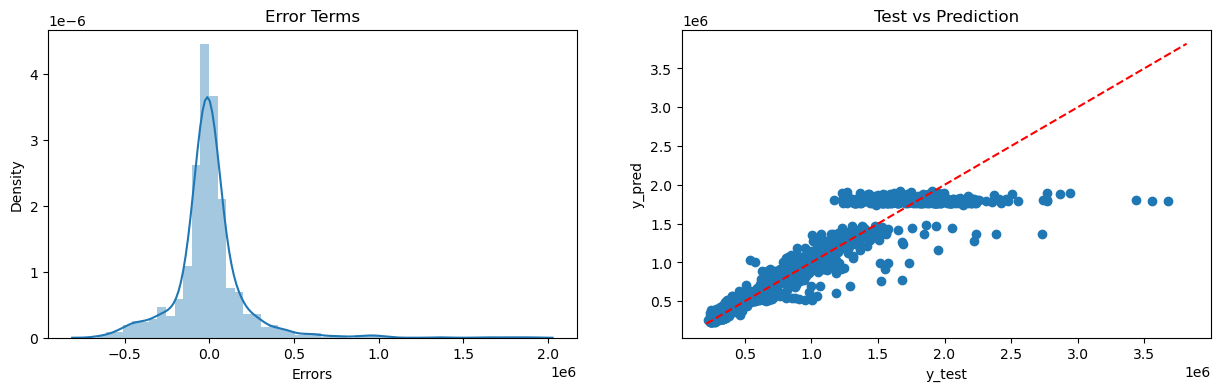



--------------------Training Set Evaluation--------------------

R2-Score on Training set ---> 0.8749008027176725

--------------------Testing Set Evaluation--------------------

R2-Score on Testing set ---> 0.8649344535560226


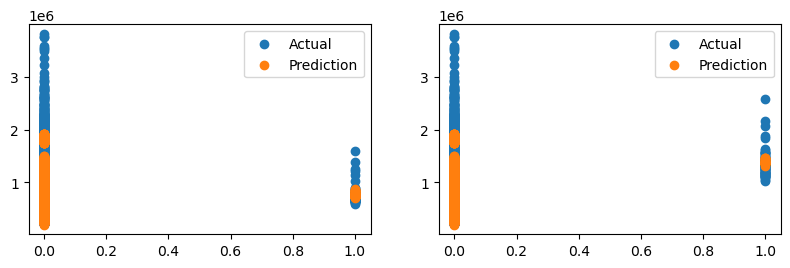

In [35]:
pred_train = MLR.predict(Train_X_std_rfe)
pred_test = MLR.predict(Test_X_std_rfe)

Evaluation(pred_train, pred_test)

**We can see that the model accuracy comes out to be 86.4% as we saw it during RFE feature selection**

### Model Training using Statsmodels

In [36]:
# Multiple Linear Regression model with statsmodels

from statsmodels.formula import api                # library used for model training ( better statisics)

train_x_y = pd.concat([Train_X_std_rfe,Train_Y.reset_index(drop=True)],axis=1)

api_model = api.ols(formula='{} ~ {}'.format(target,' + '.join(str(i) for i in Train_X_std_rfe.columns)),data=train_x_y).fit()

api_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     718.7
Date:                Thu, 15 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:12:02   Log-Likelihood:                -60851.
No. Observations:                4463   AIC:                         1.218e+05
Df Residuals:                    4419   BIC:                         1.221e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.493e+05   4512.990    166.026      0.000     7.4e+05    7.58e+05
weekday         7.271e+04   2086.567     34.848      0.000    6.86e+04    7.68e+04
Store_44         -1.5e+06   2.08e+04    -72.182      0.000   -1.54e+06   -1.46e+06
Store_45        -1.03e+06   2.02e+04    -50.875      0.000   -1.07e+06   -9.91e+05
Store_40       -8.397e+05   2.43e+04    -34.588      0.000   -8.87e+05   -7.92e+05
Store_43       -1.169e+06   2.02e+04    -57.983      0.000   -1.21e+06   -1.13e+06
Store_42       -1.247e+06   2.05e+04    -60.805      0.000   -1.29e+06   -1.21e+06
Store_41       -5.345e+05   2.07e+04    -25.835      0.000   -5.75e+05   -4.94e+05
Store_38       -1.355e+06   5.91e+04    -22.930      0.000   -1.47e+06   -1.24e+06
Store_37       -1.284e+06   2.03e+04    -63.404      0.000   -1.32e+06   -1.24e+06
weekday_4       3.004e+04   6452.056      4.656      0.000    1.74e+04    4.27e+04
Holiday_Flag_0  4.708e+05   4729.202     99.547      0.000    4.62e+05     4.8e+05
year_2012       2.283e+05   5013.294     45.540      0.000    2.18e+05    2.38e+05
year_2011       2.559e+05   4712.714     54.309      0.000    2.47e+05    2.65e+05
year_2010        2.65e+05   4780.797     55.435      0.000    2.56e+05    2.74e+05
weekday_6      -1.075e+05   8970.752    -11.985      0.000   -1.25e+05   -8.99e+04
weekday_5       -4.87e+04    1.2e+04     -4.046      0.000   -7.23e+04   -2.51e+04
weekday_3       1.154e+05   1.11e+04     10.375      0.000    9.36e+04    1.37e+05
weekday_2       1.162e+05   2.38e+04      4.892      0.000    6.96e+04    1.63e+05
weekday_1       2.625e+05   1.15e+04     22.812      0.000     2.4e+05    2.85e+05
weekday_0       3.813e+05      1e+04     38.120      0.000    3.62e+05    4.01e+05
Store_35        -8.85e+05   2.05e+04    -43.141      0.000   -9.25e+05   -8.45e+05
Store_36       -1.427e+06   2.12e+04    -67.451      0.000   -1.47e+06   -1.39e+06
Store_31       -4.097e+05   2.11e+04    -19.453      0.000   -4.51e+05   -3.68e+05
Store_34       -8.336e+05    2.1e+04    -39.758      0.000   -8.75e+05   -7.92e+05
Store_8        -8.894e+05   2.01e+04    -44.273      0.000   -9.29e+05    -8.5e+05
Store_12       -8.186e+05    5.3e+04    -15.453      0.000   -9.22e+05   -7.15e+05
Store_11       -4.453e+05    2.1e+04    -21.239      0.000   -4.86e+05   -4.04e+05
Store_9        -1.263e+06    2.2e+04    -57.432      0.000   -1.31e+06   -1.22e+06
Store_7        -1.238e+06   2.07e+04    -59.850      0.000   -1.28e+06    -1.2e+06
Store_16       -1.286e+06   2.01e+04    -64.030      0.000   -1.33e+06   -1.25e+06
Store_5        -1.489e+06   2.11e+04    -70.709      0.000   -1.53e+06   -1.45e+06
Store_3          -1.4e+06   2.07e+04    -67.684      0.000   -1.44e+06   -1.36e+06
Store_15       -1.188e+06   2.01e+04    -59.159      0.000   -1.23e+06   -1.15e+06
Store_17    

**Statsmodel is giving the summarized info about the model.**


---

#  5. Summary

- The dataset was quite smaller with about 8% outliers. Hence, processing time was never a hurdle in the project.
- Through EDA we understood some relations between different variables which helped us understand the data better and give a hint that outlier treatment and feature ellimination will be required before we train the model
- Since a lot of features had colliniarity, RFE method was used to select the most efficient features.
- Finally we have our MLR model ready which can predict weekly sales as per the given input with 87% accuracy.

---